## Loading Dataset

In [3]:
import pickle
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model, metrics, svm, neighbors, gaussian_process, ensemble, neural_network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Using TensorFlow backend.


In [28]:
df = pickle.load(open("datafiles/after-EDA.ft", "rb"))
df.head()

,totPurchaseAmt,latitude,longitude,bathrooms,bedrooms,livingArea,yearBuilt,averageSchoolRating,zip,zestimate,sentiment
1,198000.00,45.24,-93.41,2.00,4.00,1716.00,1996,5.33,55303,285985.00,0.49
3,415000.00,45.28,-93.41,2.00,3.00,3108.00,1985,6.33,55303,431995.00,0.26
4,329900.00,45.14,-93.02,3.00,4.00,1814.00,2001,6.50,55038,318162.00,0.27
5,262000.00,45.16,-93.30,2.00,3.00,2158.00,1985,4.67,55043,272169.00,0.91
6,280000.00,45.28,-93.33,2.00,3.00,1993.00,1976,7.33,55304,290365.00,0.94


In [29]:
len(df)

28078

In [30]:
grouped = df.groupby('zip')
df = grouped.filter(lambda x: x['zip'].count() > 100)

## Converting Categorical Variables 

In [31]:
df = pd.get_dummies(data=df, columns=["zip"]) #"bathrooms", "bedrooms",
df.head()

,totPurchaseAmt,latitude,longitude,bathrooms,bedrooms,livingArea,yearBuilt,averageSchoolRating,zestimate,sentiment,...,zip_55431,zip_55432,zip_55433,zip_55434,zip_55437,zip_55443,zip_55446,zip_55447,zip_55448,zip_55449
1,198000.00,45.24,-93.41,2.00,4.00,1716.00,1996,5.33,285985.00,0.49,...,0,0,0,0,0,0,0,0,0,0
3,415000.00,45.28,-93.41,2.00,3.00,3108.00,1985,6.33,431995.00,0.26,...,0,0,0,0,0,0,0,0,0,0
4,329900.00,45.14,-93.02,3.00,4.00,1814.00,2001,6.50,318162.00,0.27,...,0,0,0,0,0,0,0,0,0,0
6,280000.00,45.28,-93.33,2.00,3.00,1993.00,1976,7.33,290365.00,0.94,...,0,0,0,0,0,0,0,0,0,0
7,237000.00,45.11,-93.26,2.00,3.00,2058.00,1959,3.67,246844.00,0.99,...,0,1,0,0,0,0,0,0,0,0


## Train Test Split 

In [32]:
X = df.drop(columns=["totPurchaseAmt", "latitude", "longitude"])
y = df["totPurchaseAmt"]

X = X.drop(columns=["zestimate"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

## Models

In [34]:
def create_model(optimizer = 'adam'):
  cnn_model = Sequential()

  n_cols = X_train.shape[1]
  cnn_model.add(Dense(16, activation='relu', input_shape=(n_cols,)))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(256, activation='relu'))
  cnn_model.add(Dense(256, activation='relu'))
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dense(16, activation='relu'))
  cnn_model.add(Dense(1))

  cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=["mae"])

  return cnn_model

In [35]:
models = {
    "Neural Network" : create_model("Adam"),
    "Linear Regression" : linear_model.LinearRegression(n_jobs=-1), 
    "Support Vector Machine" : svm.SVR(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Ridge Regression" : linear_model.Ridge(alpha=.5),
    "Least Angle Regression" : linear_model.LassoLars(alpha=.1),
    "Bayesian Ridge Regression" : linear_model.BayesianRidge(),
    "SGD Regressor" : linear_model.SGDRegressor(),
    "Nearest Neighbors Regression" : neighbors.KNeighborsRegressor(n_jobs=-1),
    "Gaussian Process" : gaussian_process.GaussianProcessRegressor(),
    "Random Forest" : ensemble.RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting Regressor' : ensemble.GradientBoostingRegressor()
}

results = []

for model_name in models:
    model = models[model_name]

    if model_name == "Neural Network":
        model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print ("=== " + model_name + " ===")
    #     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    #     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    #     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #     print ('\n')
    results.append([model_name, round(metrics.mean_absolute_error(y_test, y_pred), 3),
                    round(metrics.mean_squared_error(y_test, y_pred), 3), 
                    round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)])

=== Neural Network ===
=== Linear Regression ===
=== Support Vector Machine ===
=== Decision Tree ===
=== Ridge Regression ===
=== Least Angle Regression ===
=== Bayesian Ridge Regression ===
=== SGD Regressor ===
=== Nearest Neighbors Regression ===
=== Gaussian Process ===
=== Random Forest ===
=== Gradient Boosting Regressor ===


In [36]:
pd.set_option('display.float_format', '{:.2f}'.format)

dfResults = pd.DataFrame(results, columns =['Model Name', 'MAE', 'MSE', 'RMSE']) 
dfResults.sort_values(by=["MAE"])

,Model Name,MAE,MSE,RMSE
10,Random Forest,56552.36,12581329503.20,112166.53
0,Neural Network,56578.58,12710015283.71,112738.70
11,Gradient Boosting Regressor,57604.13,13004669418.31,114038.02
6,Bayesian Ridge Regression,61307.37,13039919954.01,114192.47
5,Least Angle Regression,61382.96,13032213862.49,114158.72
4,Ridge Regression,61394.07,13031939852.91,114157.52
1,Linear Regression,61395.81,13032365047.88,114159.38
7,SGD Regressor,61589.09,13164414150.48,114736.28
8,Nearest Neighbors Regression,61938.84,13552520140.53,116415.29
3,Decision Tree,79866.88,25779312636.49,160559.37


In [27]:
pd.set_option('display.float_format', '{:.2f}'.format)

dfResults = pd.DataFrame(results, columns =['Model Name', 'MAE', 'MSE', 'RMSE']) 
dfResults.sort_values(by=["MAE"])

,Model Name,MAE,MSE,RMSE
10,Random Forest,56279.46,11620028230.26,107796.24
0,Neural Network,56552.90,16112258683.05,126934.07
11,Gradient Boosting Regressor,57977.30,12218469359.82,110537.18
6,Bayesian Ridge Regression,60965.38,13173525562.82,114775.98
5,Least Angle Regression,61064.90,13170807893.70,114764.14
4,Ridge Regression,61075.13,13171606966.81,114767.62
1,Linear Regression,61968.55,13136156402.49,114613.07
8,Nearest Neighbors Regression,65673.85,15510598684.52,124541.55
3,Decision Tree,77267.06,19748369683.68,140528.89
2,Support Vector Machine,106395.28,33703071704.63,183583.96


## Feature Importance

In [37]:
model = ensemble.RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

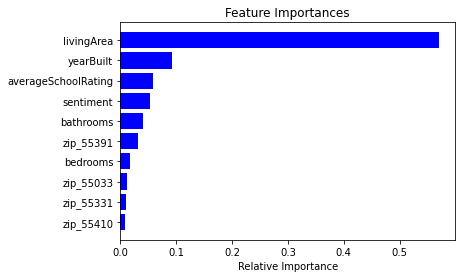

In [49]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Grid Search for Best HyperParameter

In [41]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = ensemble.RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_split=5,
                      n_estimators=400)

In [43]:
y_pred = rf_random.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('\n')

Mean Absolute Error: 53839.61040534441
Mean Squared Error: 11723129631.063478
Root Mean Squared Error: 108273.40223278974


